In [22]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *
from data_path import data_path

In [23]:
handle = sigmf.sigmffile.fromfile(data_path + '/763MHz_15360KSPS.sigmf-data')
delta_f = 450e3
f = 763e6
mu = 0
apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile(data_path + '/3627MHz_30720KSPS.sigmf-data')
# delta_f = -600e3
# f = 3672e6
# mu = 1
# apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
# delta_f = 0
# f = 1
# mu = 0
# apply_fine_CFO = 0

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)

In [24]:
waveform =  waveform * np.exp(-1j*2*np.pi*delta_f/fs*(np.arange(len(waveform))))

detected NID2 is 0


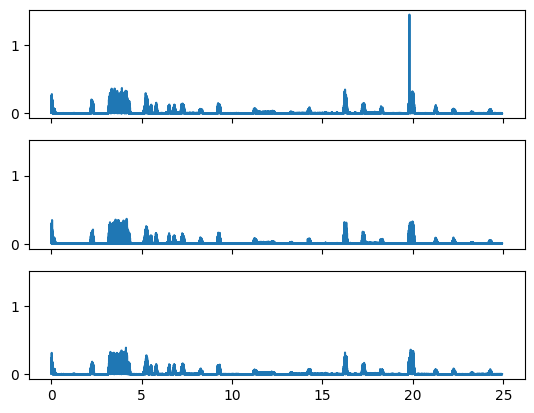

In [25]:
carrier = nrCarrierConfig(NSizeGrid = 106, SubcarrierSpacing = 15 * 2**mu)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((635-63), (635+64))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, SampleRate = fs)
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

    temp = scipy.signal.correlate(waveform[:int(25e-3 * fs)], refWaveform, 'valid')  # correlate over 25 ms
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/fs*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2}')

In [26]:
nrbSSB = 20
scsSSB = 15 * 2**(mu)
nSlot = 0
rxSampleRate = fs
if False:
    cp1 = np.round(5.2e-6*fs * 2**(-mu))
    cp2 = np.round(4.7e-6*fs * 2**(-mu))
    timingOffset = int(35264 - 2048 - cp1 - cp2)
else:
    nrbSSB = 20
    refGrid = np.zeros((nrbSSB*12, 2))
    refGrid[nrPSSIndices(), 1] = nrPSS(detected_NID2)
    timingOffset = nrTimingEstimate(waveform = waveform, nrb = nrbSSB, scs = scsSSB, initialNSlot = nSlot, refGrid = refGrid, SampleRate = rxSampleRate)

In [27]:
# modulate about 8 symbols, only has to be at least 5
rxGrid = nrOFDMDemodulate(waveform = waveform[timingOffset:][:np.min((len(waveform), 2048*8))], nrb = nrbSSB, scs = scsSSB, initialNSlot = nSlot, SampleRate=rxSampleRate)
rxGrid = rxGrid[:,1:5]
rxGrid /= np.max((rxGrid.real.max(), rxGrid.imag.max()))

Text(0.5, 0.95, 'SSS symbols')

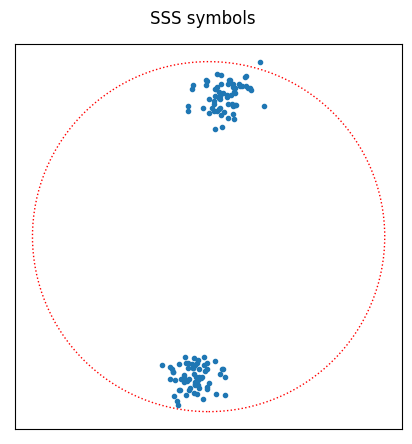

In [28]:
sssIndices = nrSSSIndices()
sssRx = nrExtractResources(sssIndices, rxGrid)
sssRx /= np.max((sssRx.real.max(), sssRx.imag.max())) # scale sssRx symbols individually

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(sssRx.real, sssRx.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols', y=0.95)

detected NID1 is 103
detected NID is 309


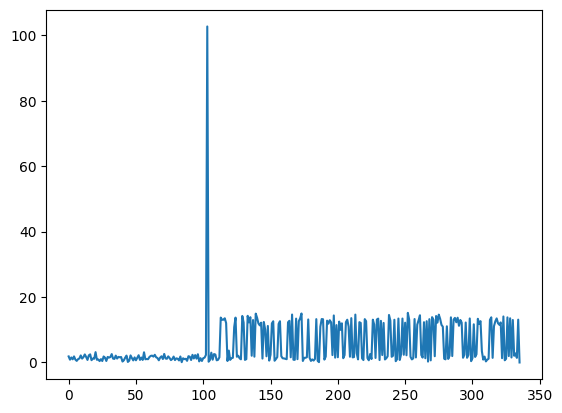

In [29]:
sssEst = np.zeros(336)
for NID1 in range(335):
    ncellid = (3*NID1) + detected_NID2
    sssRef = nrSSS(ncellid)
    sssEst[NID1] = np.abs(np.vdot(sssRx, sssRef))

detected_NID1 = np.argmax(sssEst)
detected_NID = detected_NID1*3 + detected_NID2
print(f'detected NID1 is {detected_NID1}')
print(f'detected NID is {detected_NID}')
plt.plot(sssEst)
plt.show()

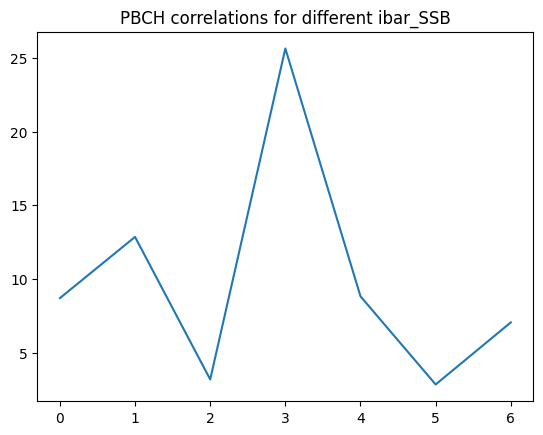

ibar_SSB is 3


In [30]:
dmrsIndices = nrPBCHDMRSIndices(detected_NID, style='matlab')
xcorrPBCHDMRS = np.empty(7)
for ibar_SSB in range(7):
    PBCHDMRS = nrPBCHDMRS(detected_NID, ibar_SSB)
    xcorrPBCHDMRS[ibar_SSB] = np.abs(np.vdot(nrExtractResources(dmrsIndices, rxGrid), PBCHDMRS))
ibar_SSB = np.argmax(np.abs(xcorrPBCHDMRS))

plt.plot(np.abs(xcorrPBCHDMRS))
plt.title('PBCH correlations for different ibar_SSB')
plt.show()
print(f'ibar_SSB is {ibar_SSB}')

In [31]:
refGrid = np.zeros((nrbSSB*12, 4), 'complex')
dmrsIndices = nrPBCHDMRSIndices(detected_NID)

if False:
    refGridFlat = refGrid.ravel(order='F')
    refGridFlat[dmrsIndices] = nrPBCHDMRS(detected_NID, ibar_SSB)
    refGrid = refGridFlat.reshape(refGrid.shape, order='F')

    refGridFlat = refGrid.ravel(order='F')
    refGridFlat[sssIndices] = nrSSS(detected_NID)
    refGrid = refGridFlat.reshape(refGrid.shape, order='F')
else:
    nrSetResources(dmrsIndices, refGrid, nrPBCHDMRS(detected_NID, ibar_SSB))

Text(0.5, 0.95, 'wiped PBCHDMRS symbols')

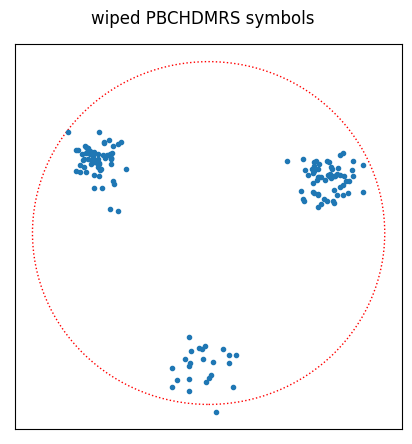

In [32]:
PBCHDMRS_wiped = nrExtractResources(dmrsIndices, rxGrid) / nrExtractResources(dmrsIndices, refGrid)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(PBCHDMRS_wiped.real, PBCHDMRS_wiped.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('wiped PBCHDMRS symbols', y=0.95)

/mnt/d/git/py3gpp/py3gpp/nrChannelEstimate.py:18: RuntimeWarning: divide by zero encountered in true_divide
  normGrid = rxGrid/refGrid


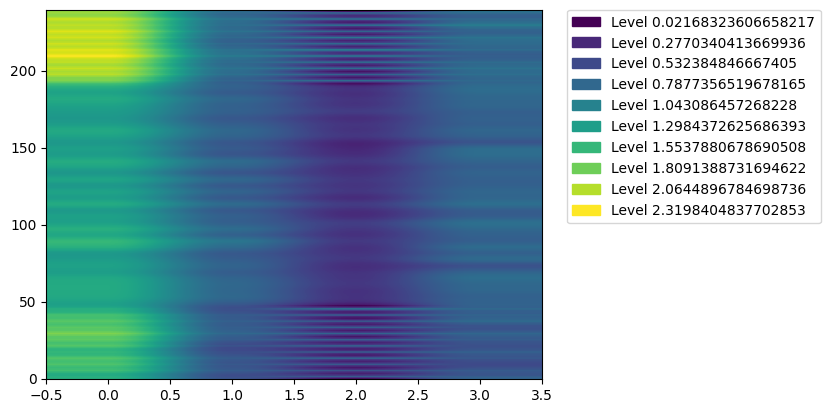

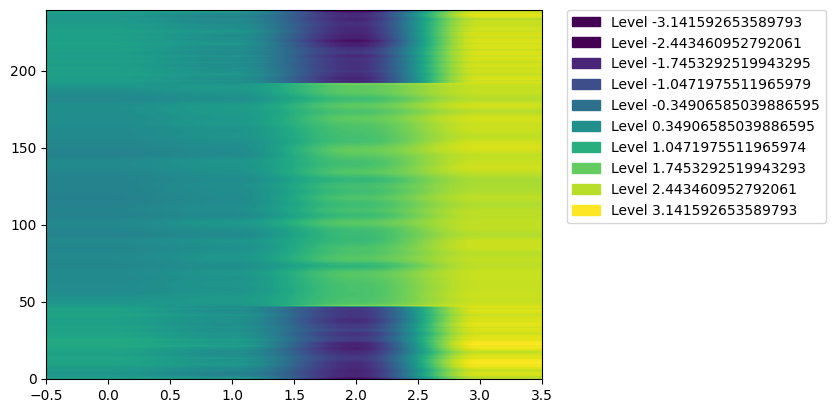

In [33]:
import matplotlib.patches as mpatches 
H = nrChannelEstimate(rxGrid = rxGrid, refGrid = refGrid)
im = plt.imshow(np.abs(H), origin='lower', aspect='auto')
values = np.linspace(np.min(np.abs(H)), np.max(np.abs(H)), 10)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

im = plt.imshow(np.angle(H), origin='lower', aspect='auto')
values = np.linspace(-np.pi, np.pi, 10)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()
pass


Text(0.5, 0.95, 'equilized PBCHDMRS symbols')

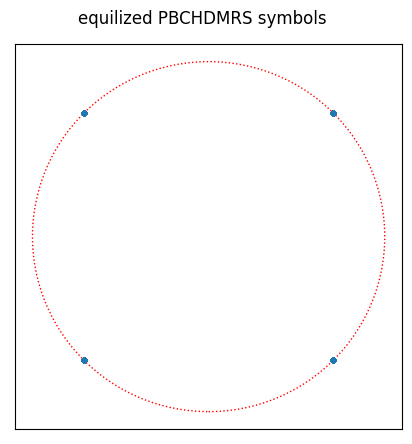

In [34]:
PBCHDMRS_wiped = nrExtractResources(dmrsIndices, rxGrid/H)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(PBCHDMRS_wiped.real, PBCHDMRS_wiped.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('equilized PBCHDMRS symbols', y=0.95)

Text(0.5, 0.95, 'equilized PBCH symbols')

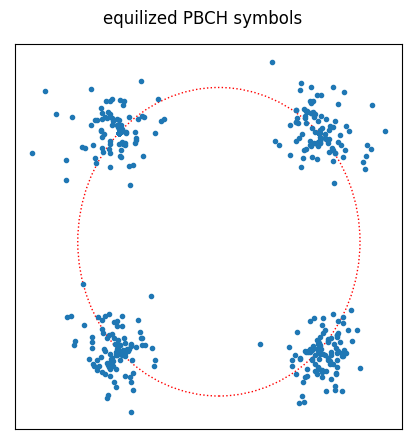

In [35]:
pbch_eqed = nrExtractResources(np.hstack((np.arange(240,480), np.arange(720,960))), rxGrid/H)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(pbch_eqed.real, pbch_eqed.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('equilized PBCH symbols', y=0.95)